In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '.')
import streamlit as st

In [2]:
class DbConn:

    def __init__(self) -> None:
        self.conn = sqlite3.connect("../data/latest.db") 

    def execute_sql(self, query:str, params:dict = None, return_df:bool = True): 

        cur = self.conn.cursor() 
        try:
            if params is not None:
                cur.execute(query, params) 
            else:
                cur.execute(query) 
            if return_df:
                column_names = [col[0] for col in cur.description] 
                query_data = cur.fetchall() 
                query_df = pd.DataFrame.from_records(query_data, columns=column_names) 
                res = query_df 

            return res 
        finally:
            cur.close() 

    def commit(self):
        self.conn.commit() 
        self.conn.close() 

def getLvl1Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 1;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  

    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    return df

def getLvl2Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 2;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  
    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    st.session_state['downloaded_lvl2_data'] = True

    return df

In [3]:
def epidemiological_features():
    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']
    return epidemiological_features 
    
def get_feature_time_series_lvl_1(df:pd.DataFrame, feature:str, administrative_area_level_1:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 1 and administrative_area_level_1 == @administrative_area_level_1')

    df = df[['date', feature]] 

    df['date'] = pd.to_datetime(df['date'])

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

def get_feature_time_series_lvl_2(df:pd.DataFrame, feature:str, administrative_area_level_2:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 2 and administrative_area_level_2 == @administrative_area_level_2')

    df = df[['date', feature]] 

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df  

def get_feature_time_series_lvl_3(df:pd.DataFrame, feature:str, administrative_area_level_3:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 3 and administrative_area_level_3 == @administrative_area_level_3')

    df = df[['date', feature]] 

    df = df.set_index('date')


    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

In [4]:
df = getLvl1Data() 
#dados confirmados brazil 

data = get_feature_time_series_lvl_1(df, feature='confirmed', administrative_area_level_1='Brazil')

In [7]:
def train_test_split(stationary_ts, proportion=80):
    train_size = int((proportion/100)*len(stationary_ts))
    train, test = stationary_ts[:train_size], stationary_ts[train_size:]

    print(train_size, (len(stationary_ts)-train_size))

    return train, test

In [8]:
train, test = train_test_split(data, proportion=90)

1010 113


In [14]:
train['confirmed'] = train['confirmed'].diff().fillna(0)
test['confirmed'] = test['confirmed'].diff().fillna(0)

C:\Users\heito\AppData\Local\Temp\ipykernel_34788\302973438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['confirmed'] = train['confirmed'].diff().fillna(0)
C:\Users\heito\AppData\Local\Temp\ipykernel_34788\302973438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['confirmed'] = test['confirmed'].diff().fillna(0)


## Analise de Residuos dos Modelos

### Modelos

In [37]:
import streamlit as st
import pandas as pd
from typing import Union, Optional
import matplotlib.pyplot as plt 
import numpy as np
from statsmodels.tsa.ar_model import AutoReg, ar_select_order 
from statsmodels.tsa.arima.model import ARIMA 
from pmdarima.arima import auto_arima


def AutoRegressiveModel(train: pd.Series, steps, lags: Optional[Union[list[int], int]]=None, max_lags: Optional[int | None] = None):
    if lags is None:
        if max_lags is None:
            raise ValueError("argumento `max_lags` não pode ser vazio quando `lags` é vazio")
        # Realiza seleção automática de Lags
        selector = ar_select_order(train, maxlag=max_lags)
        ar_model = AutoReg(train, lags=selector.ar_lags)
        ar_model_fit = ar_model.fit()

        # Get forecast and confidence intervals
        forecast_results = ar_model_fit.get_prediction(start=len(train), end=len(train) + steps - 1, dynamic=False)
        forecast_values = forecast_results.predicted_mean
        confidence_intervals = forecast_results.conf_int()

        return forecast_values, confidence_intervals

    else:
        if max_lags is not None:
            raise ValueError("O argumento `max_lags` deve ser usado apenas quando o argumento `lags` não é especificado")
        else:
            ar_model = AutoReg(train, lags=lags)
            ar_model_fit = ar_model.fit() 

            # Get forecast and confidence intervals
            forecast_results = ar_model_fit.get_prediction(start=len(train), end=len(train) + steps - 1, dynamic=False)
            forecast_values = forecast_results.predicted_mean
            confidence_intervals = forecast_results.conf_int()

            return forecast_values, confidence_intervals
        
def MovingAverageModel(train:pd.Series, q:int, steps:int):
    ma_model = ARIMA(endog=train, order=(0,0,q)).fit() 

    #Forecasts 
    forecasts = ma_model.get_forecast(steps=steps) 
    forecast_values = forecasts.predicted_mean 
    forecast_conf_int = forecasts.conf_int() 
    
    return forecast_values, forecast_conf_int 

def ARMAModel(train:pd.Series, p:int, q:int, steps:int):
    arma_model = ARIMA(endog=train, order=(p,0,q)).fit() 

    #Forecasts 
    forecasts = arma_model.get_forecast(steps=steps) 
    forecast_values = forecasts.predicted_mean 
    forecast_conf_int = forecasts.conf_int() 
    
    return forecast_values, forecast_conf_int

def ARIMAModel(train: pd.Series, steps:int, p: Optional[int] = None, d: Optional[int] = None, q: Optional[int] = None, auto: bool = False):

    if auto:
        auto_arima_model = auto_arima(train, alpha=0.05, stepwise=True, n_jobs=-1)
        model_order = auto_arima_model.order 
        auto_arima_model_fit = auto_arima_model.fit(train) 

        # Forecast future values (adjust the forecast horizon as needed)
        forecast, conf_int = auto_arima_model_fit.predict(n_periods=steps, return_conf_int=True)
        conf_int = pd.DataFrame(conf_int) 
        
        return forecast, conf_int, model_order
    
    arima_model_fit = ARIMA(train, order=(p,d,q)).fit() 

    #Forecasts 
    forecasts = arima_model_fit.get_forecast(steps=steps) 
    forecast_values = forecasts.predicted_mean 
    forecast_conf_int = forecasts.conf_int() 
    
    return forecast_values, forecast_conf_int

def SARIMAModel(train:pd.Series):
    pass

#Plotting Functions 

def plot_test_data_forecast(test:pd.Series, forecasts:pd.Series, conf_int:pd.DataFrame):
    # Plot the test data against the forecasted values
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(np.arange(len(test)), test, label='Dado de Teste', linestyle='--')
    ax.plot(np.arange(len(test)), forecasts, label='Previsão')
    ax.fill_between(np.arange(len(test)),
                    conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% IC')
    ax.legend()
    st.pyplot(fig)

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot 
from statsmodels.graphics.tsaplots import plot_acf

def residual_analysis(residual:pd.DataFrame):

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

    # plot[1,1]
    residual.plot(ax=axs[0,0])
    axs[0,0].set_title("Residuals");

    # plot
    sns.distplot(residual, ax=axs[0,1]);
    axs[0,1].set_title("Density plot - Residual");

    # # plot
    qqplot(residual['residuals'], line='q', fit=True, ax=axs[1,0])
    axs[1,0].set_title('Plot Q-Q')

    # plot
    plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia", auto_ylims=True)
    axs[1,1].set_title("Autocorrelation");

    plt.show()

Adicionando residuos no resultado do ajuste

In [51]:
def ARIMAModel(train: pd.Series, steps:int, p: Optional[int] = None, d: Optional[int] = None, q: Optional[int] = None, auto: bool = False):

    if auto:
        auto_arima_model = auto_arima(train, alpha=0.05, stepwise=True, n_jobs=-1)
        model_order = auto_arima_model.order 
        auto_arima_model_fit = auto_arima_model.fit(train) 

        # Forecast future values (adjust the forecast horizon as needed)
        forecast, conf_int = auto_arima_model_fit.predict(n_periods=steps, return_conf_int=True)
        conf_int = pd.DataFrame(conf_int)
        residuals = pd.DataFrame(auto_arima_model_fit.resid(), columns=['residuals']).reset_index()
        
        return forecast, conf_int, residuals['residuals'], model_order
    
    arima_model_fit = ARIMA(train, order=(p,d,q)).fit() 

    #Forecasts 
    forecasts = arima_model_fit.get_forecast(steps=steps) 
    forecast_values = forecasts.predicted_mean 
    forecast_conf_int = forecasts.conf_int()
    residuals = pd.DataFrame(arima_model_fit.resid, columns=['residuals']).reset_index()
    
    return forecast_values, forecast_conf_int, residuals

In [53]:
forecast_values, confidence_intervals, residuals, model_order = ARIMAModel(train, steps=len(test), auto=True)

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [54]:
residuals

0           0.000000
1           0.000000
2           0.000000
3           1.000000
4          -1.435590
            ...     
1005   -10795.270658
1006    -8602.520749
1007     6910.860724
1008    20394.210503
1009    -4975.719402
Name: residuals, Length: 1010, dtype: float64

In [61]:
import pandas as pd
import streamlit as st
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot 
from statsmodels.graphics.tsaplots import plot_acf

def residual_analysis(residual:pd.DataFrame):

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

    # plot[1,1]
    residual.plot(ax=axs[0,0])
    axs[0,0].set_title("Resíduos");

    # plot
    sns.distplot(residual, ax=axs[0,1]);
    axs[0,1].set_title("Densidade - Resíduos");

    # # plot
    qqplot(residual, line='q', fit=True, ax=axs[1,0])
    axs[1,0].set_title('Q-Q Plot ')

    # plot
    plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia", auto_ylims=True)
    axs[1,1].set_title("Autocorrelação");

    plt.show()

C:\Users\heito\AppData\Local\Temp\ipykernel_34788\4220600851.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual, ax=axs[0,1]);


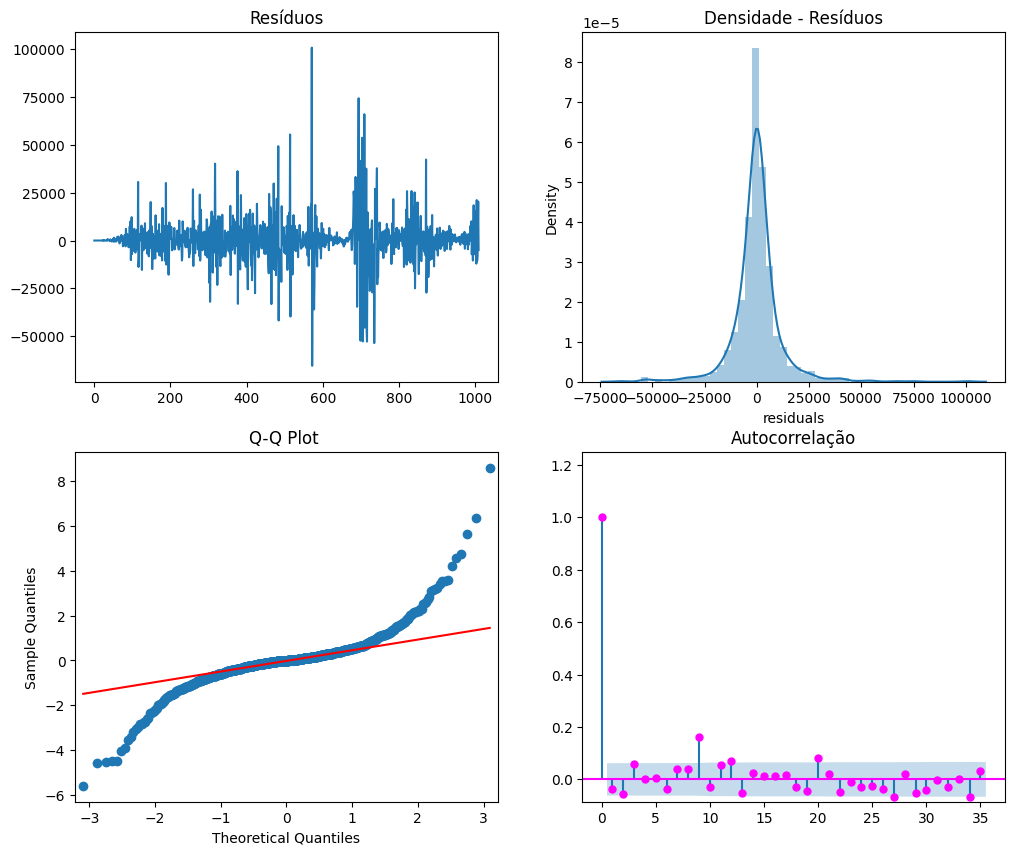

In [62]:
residual_analysis(residuals)